# Dynamic Linear Model

In [5]:
import os
import math

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.contrib.tracking.extended_kalman_filter import EKFState
from pyro.contrib.tracking.distributions import EKFDistribution
from pyro.contrib.tracking.dynamic_models import NcvContinuous
from pyro.contrib.tracking.measurements import PositionMeasurement
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam
from pyro.ops.stats import quantile

from main import get_energy_data, get_weather_data
import pandas as pd
import matplotlib.pyplot as plt

pyro.set_rng_seed(20200928)
torch.manual_seed(20200101)

pd.set_option('display.max_rows', 500)



## Data

In [2]:
# read data
df = pd.read_csv("preprocessed_data/df.csv")#.iloc[:1000]
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)#'%Y-%m-%d %H:%M:%S.%f') # 2015-01-01 10:00:00+00:00
df = df.groupby("time_str").mean()
df = df.reset_index().set_index('time_str')
df.index.name = None
df = df.asfreq("D") # aggregate data, can be commented out to use all data
dfW = get_weather_data(df)
dfE = get_energy_data(df)

# convert to torch tensors
X_W = torch.from_numpy(dfW.values).float()
X_E = torch.from_numpy(dfE.values).float()
obs = torch.from_numpy(df["price actual"].values).float()


# translate to pyro forecasting language
T = None # number of time steps to include, if None all data is used
y = obs.unsqueeze(-1) if T is None else obs[-T:].unsqueeze(-1)
covariates = torch.hstack((X_E, X_W)) if T is None else torch.hstack((X_E, X_W))[-T:]
# covariates = X_E if T is None else X_E[-T:]

# define constants
n, p = covariates.shape
dates = df.index[-n:] # used for plotting

# start, train end, test end
T0 = 0
T1 = n - n//10 # 10 % test data
T2 = n
print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)

Number of observations: 1461
Number of training observations: 1315
Number of test observations: 146


## Model

INFO 	 step    0 loss = 4.49627e+08


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step  100 loss = 295.339


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step  200 loss = 274.029


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step  300 loss = 267.18


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step  400 loss = 263.908


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step  500 loss = 261.66


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step  600 loss = 259.236


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step  700 loss = 257.214


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step  800 loss = 255.796


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step  900 loss = 254.442


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step 1000 loss = 253.337


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step 1100 loss = 252.111


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step 1200 loss = 251.653


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step 1300 loss = 250.751


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step 1400 loss = 250.14


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step 1500 loss = 249.564


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step 1600 loss = 249.092


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step 1700 loss = 249.039


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step 1800 loss = 248.582


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

INFO 	 step 1900 loss = 248.305


theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
theta_g:  torch.Size([10])
t

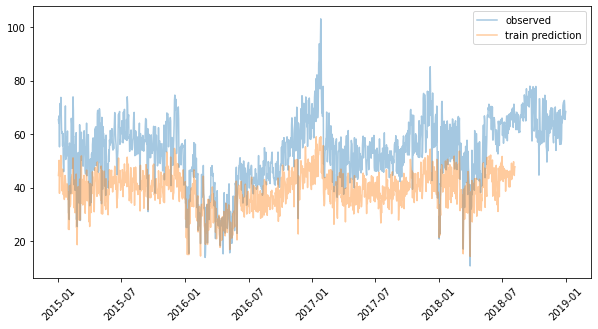

In [34]:
class VanillaDLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        self.h_dim = X_E.shape[1]
        self.gamma = 1e-6

    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        covariates = x_E

        h_dim = 8
        M = 5
        tau = 1
        gamma = 1
        lambda_g = 1
        lambda_f = 1
        sigma_beta = 1
        sigma_alpha = 1

        duration, data_dim = zero_data.size()
        feature_dim = covariates.size(-1)

        X = torch.cat([x_E, x_W], dim=1)
        y_obs = None
        y_pred = None

        season_plate = pyro.plate("season", M)
        with season_plate:
            sigma = pyro.sample("sigma", dist.HalfCauchy(tau))
            R = pyro.sample("R", dist.HalfCauchy(torch.ones(h_dim) * gamma).to_event(1))
            theta_g = pyro.sample("theta_g", dist.Normal(torch.zeros(h_dim), torch.ones(h_dim) * lambda_g).to_event(1))
            theta_f = pyro.sample("theta_f", dist.Normal(torch.zeros((h_dim, X.shape[1])), torch.ones((h_dim, X.shape[1])) * lambda_f).to_event(2))
            alpha = pyro.sample("alpha", dist.Normal(torch.zeros(M), sigma_alpha * torch.ones(M)).to_event(1))
            beta = pyro.sample("beta", dist.Normal(torch.zeros(x_W.shape[1]), sigma_beta * torch.ones(x_W.shape[1])).to_event(1))
            h = pyro.sample("h_0", dist.Normal(torch.zeros(h_dim), torch.ones(h_dim)).to_event(1))
        
        z = pyro.sample("z_0", dist.Categorical(torch.ones(M) / M), infer={"enumerate": "parallel"})

        for t in pyro.markov(range(duration)):
            z_logits = x_W[t] @ beta.T + alpha[z]
            z = pyro.sample(f"z_{t+1}", dist.Categorical(logits=z_logits), infer={"enumerate": "parallel"})

            with season_plate:
                h_mean = h + theta_f @ X[t]
                h = pyro.sample(f"h_{t+1}", dist.Normal(h_mean, R).to_event(1))

            y_mean = h @ theta_g.T
            # print(y_mean[z].shape, obs[t].shape)
            # if t < T:
            # y_obs = pyro.sample(f"y_obs_{t+1}", dist.Normal(y_mean[z], sigma[z]).to_event(1), obs=obs[t])
            # else:
            # y_pred = pyro.sample(f"y_pred_{t+1}", dist.Normal(y_mean[z], sigma[z]).to_event(1))

            # print(y_obs)




pyro.set_rng_seed(1)
pyro.clear_param_store()
model = VanillaDLM()
guide = AutoNormal(poutine.block(model, hide=[f"z_{i}" for i in range(T1+1)]))
# optim = Adam({ 'lr': 1e-3 })
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=2000,
    guide = guide,
    # optim = optim,
)

with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(dates, y, label="observed", alpha= .4)
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
# ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

## Inference

In [ ]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = VanillaDLM()
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
)

In [30]:
pyro.set_rng_seed(1)
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

# posterior_samples["prediction"].shape


## Analyze posterior samples

In [31]:
posterior_samples.keys()

dict_keys(['particles', 'time', 'drift_scale', 'drift_decentered', 'drift', 'weight', 'prediction', 'noise_scale', 'residual'])

In [32]:
# extract percentiles of the posterior samples
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)

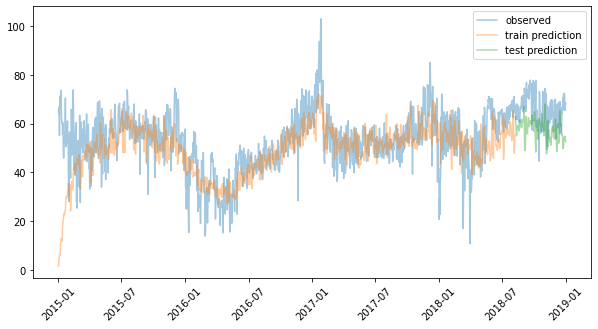

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

Mean price:  tensor(53.7429)
Mean abs residual:  tensor(12.9040)
Mean abs train residual:  tensor(12.5122)
Mean abs residual:  tensor(16.4330)


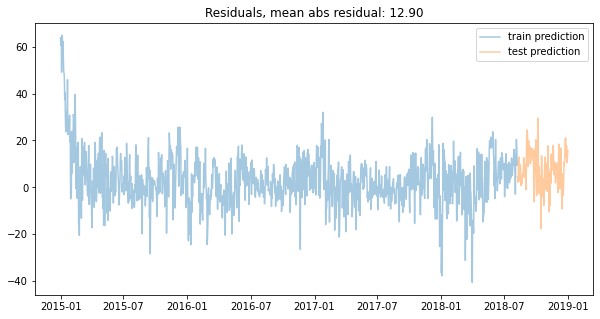

In [34]:
resid = obs - posterior_samples['prediction'].squeeze()

resid_p10, resid_p50, resid_p90 = quantile(resid, (0.1, 0.5, 0.9)).squeeze(-1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], resid_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], resid_p50[T1:], label="test prediction", alpha = .4)
# ax.fill_between(dates, resid_p10, resid_p90, color="red", alpha=0.3)
ax.legend()
ax.set_title("Residuals, mean abs residual: {:.2f}".format(resid.abs().mean()))

print("Mean price: ", obs.mean())
print("Mean abs residual: ", resid.abs().mean())
print("Mean abs train residual: ", resid[:, :T1].abs().mean())
print("Mean abs residual: ", resid[:, T1:].abs().mean())

In [35]:
# resid[T1:]
resid.shape

torch.Size([100, 1461])